# Hackaton Big Data

O primeiro desafio consiste em um cenário de previsão, onde o objetivo será prever o
faturamento de cada uma das franquias de uma rede de lojas, onde as franquias estão
espalhadas em todo o Brasil.

O segundo desafio consiste em um cenário de expansão, onde o objetivo será prever o
faturamento que uma loja teria caso ela existisse em uma região que a franquia ainda
não atua.

Este tipo de problema é muito importante para uma rede de franquias existente. A
previsão do faturamento é importante para que a franquia possa ter uma estimativa da
quantia que ela terá disponível para realizar investimentos e expansão das lojas. A
previsão do faturamento em regiões que a loja não atua é importante para que a
franquia possa realizar uma expansão mirando as regiões em que ela teria o maior
faturamento possível.

## Desafio
* O desafio proposto é inspirado no produto TargAtom da Big Data e consiste em
duas etapas:
    1. **Prever o faturamento de lojas existentes na base de dados**
        *  Neste desafio as equipes deverão prever a média do faturamento mensal dos
primeiros três meses de 2018 de cada loja presente na base de dados
disponibilizada.
    2. **Projetar o faturamento de novas lojas**
        *  Neste desafio as equipes deverão prever a média do faturamento mensal dos
primeiros três meses de 2018 caso a loja existisse em uma região especificada.

## Dados disponibilizados 

* Serão disponibilizados três arquivos
    * faturamento_lojas_atuais.csv: Faturamento mensal das lojas, contendo informações dos anos de 2016 e 2017
    * lojas_atuais.csv: Não iremos disponibilizar uma descrição das variáveis presentes neste arquivo. Elas representam as características das lojas, como a metragem, número de cadeiras, número de funcionários, etc. Este arquivo também contém asinformações da localização da loja. As colunas de localização serão o código do município e código da área de ponderação. Estes códigos são os mesmos utilizados pelo IBGE
    * cenarios_exapansao.csv: Dados cadastrais de lojas para serem utilizadas no desafio 2. Este arquivo contém as mesmas informações contidas no arquivo lojas_atuais.csv
* Durante o desafio, as equipes poderão utilizar quaisquer outras fontes de dados
não disponibilizados pela Big Data.

In [85]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
import xgboost
import sklearn
from xgboost import plot_importance
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn import linear_model
from sklearn import tree 
sns.set_style('darkgrid')
pd.set_option('float_format', '{:.2f}'.format)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [86]:
print(xgboost.__version__)

0.90


In [87]:
print(sklearn.__version__)

0.22.2.post1


In [88]:
cenario_expansao = pd.read_csv("./data/cenarios_expansao.csv")
faturamento_lojas_atuais = pd.read_csv("./data/faturamento_lojas_atuais.csv")
lojas_atuais = pd.read_csv("./data/lojas_atuais.csv")

## 1. Descrição dos dados

In [89]:
lojas_atuais.head()

cod_loja         cod_ap  cod_municipio           feature_01  \
0         1  4125506005002        4125506                  NaN   
1         2  5300108005004        5300108                  NaN   
2         3  3550308005052        3550308                  NaN   
3         4  3145604003002        3145604                  NaN   
4         5  1600303005010        1600303  FEATURE_01_VALUE_10   

            feature_02  feature_03  feature_04           feature_05  \
0  FEATURE_02_VALUE_04        True       21.76  FEATURE_05_VALUE_04   
1  FEATURE_02_VALUE_03        True       22.00  FEATURE_05_VALUE_03   
2  FEATURE_02_VALUE_03        True       45.66  FEATURE_05_VALUE_03   
3  FEATURE_02_VALUE_04       False       30.00  FEATURE_05_VALUE_03   
4  FEATURE_02_VALUE_02       False       62.49  FEATURE_05_VALUE_03   

   feature_06  feature_07  ...  feature_09  feature_10           feature_11  \
0          31        0.17  ...      115.96        2.35                  NaN   
1          27        0.22  ...     1562.67        3.67                  NaN   
2           6        0.19  ...     5593.91        2.82                  NaN   
3           3        0.14  ...       12.82        7.22                  NaN   
4          30        0.11  ...      325.53        1.97  FEATURE_11_VALUE_02   

            feature_12 feature_13  feature_14  feature_15  feature_16  \
0                  NaN        nan         nan         nan         nan   
1                  NaN        nan         nan         nan         nan   
2                  NaN        nan         nan         nan         nan   
3                  NaN        nan         nan         nan         nan   
4  FEATURE_12_VALUE_01     100.00       88.10      100.00      100.00   

   feature_17  feature_18  
0         nan         nan  
1         nan         nan  
2         nan         nan  
3         nan         nan  
4       88.50       93.80  

[5 rows x 21 columns]

In [90]:
faturamento_lojas_atuais.head()

cod_loja   ano  mes categoria   qtde  receita
0         1  2016    1  CATEG_01 301.00  9164.86
1         1  2016    2  CATEG_01 187.00  8175.55
2         1  2016    3  CATEG_01 242.00 10521.67
3         1  2016    4  CATEG_01 104.00  4560.91
4         1  2016    5  CATEG_01 100.00  4263.30

In [91]:
cenario_expansao.head()

cod_loja         cod_ap  cod_municipio           feature_01  \
0        10  2933307005008        2933307  FEATURE_01_VALUE_08   
1        13  2916401003002        2916401  FEATURE_01_VALUE_10   
2        16  2928703003003        2928703                  NaN   
3        21  2906006003001        2906006                  NaN   
4        28  3550308005058        3550308  FEATURE_01_VALUE_10   

            feature_02  feature_03  feature_04           feature_05  \
0  FEATURE_02_VALUE_02       False       50.00  FEATURE_05_VALUE_03   
1  FEATURE_02_VALUE_04       False       41.00  FEATURE_05_VALUE_03   
2  FEATURE_02_VALUE_04       False       42.12  FEATURE_05_VALUE_05   
3  FEATURE_02_VALUE_04       False       30.00  FEATURE_05_VALUE_03   
4  FEATURE_02_VALUE_02        True       44.31  FEATURE_05_VALUE_03   

   feature_06  feature_07  ...  feature_09  feature_10           feature_11  \
0           6        0.13  ...      116.19        2.91  FEATURE_11_VALUE_01   
1           4        0.12  ...       26.35        1.31                  NaN   
2           2        0.10  ...       35.36        1.97                  NaN   
3           6        0.13  ...        9.86        1.38                  NaN   
4           8        0.19  ...     5593.91        2.82  FEATURE_11_VALUE_02   

            feature_12 feature_13  feature_14  feature_15  feature_16  \
0  FEATURE_12_VALUE_01     100.00       93.40      100.00      100.00   
1                  NaN      84.30       77.50      100.00      100.00   
2                  NaN        nan         nan         nan         nan   
3                  NaN      85.00       76.90      100.00      100.00   
4  FEATURE_12_VALUE_01        nan         nan         nan         nan   

   feature_17  feature_18  
0       71.70       88.80  
1       63.50       78.80  
2         nan         nan  
3      100.00       92.90  
4         nan         nan  

[5 rows x 21 columns]

### 1.1 Dimensão dos dados

In [92]:
print("Lojas Atuais:", lojas_atuais.shape)
# Total de 3130 lojas com 21 features
print("Lojas Expansão:", cenario_expansao.shape)
# Total de 553 lojas com as mesmas 21 features
print("Faturamento:", faturamento_lojas_atuais.shape)
# Mais de 1 milhão de linhas sobre faturamento e produtos vendidos por cada categoria

Lojas Atuais: (3130, 21)
Lojas Expansão: (553, 21)
Faturamento: (1003094, 6)


### 1.2  Verificação de dados faltantes

In [93]:
lojas_atuais.isnull().sum()/len(lojas_atuais)

cod_loja        0.00
cod_ap          0.00
cod_municipio   0.00
feature_01      0.63
feature_02      0.00
feature_03      0.00
feature_04      0.00
feature_05      0.00
feature_06      0.00
feature_07      0.00
feature_08      0.00
feature_09      0.00
feature_10      0.00
feature_11      0.92
feature_12      0.92
feature_13      0.72
feature_14      0.72
feature_15      0.72
feature_16      0.72
feature_17      0.72
feature_18      0.72
dtype: float64

* Pelos dados acima, as features com mais dados faltantes são feature_11 e feature_12 com aproximadamente 92% de dados daltantes. O que pode ocasionar a seleção de modelos como XGBoost ou a inputação de dados através de alguma técnica estatística simples ou complexa. As feature_13 adiante possuem aproximadamente 72% dos dados nulos. 

In [94]:
cenario_expansao.isnull().sum()/len(cenario_expansao)

cod_loja        0.00
cod_ap          0.00
cod_municipio   0.00
feature_01      0.66
feature_02      0.00
feature_03      0.00
feature_04      0.00
feature_05      0.00
feature_06      0.00
feature_07      0.00
feature_08      0.00
feature_09      0.00
feature_10      0.00
feature_11      0.93
feature_12      0.93
feature_13      0.71
feature_14      0.71
feature_15      0.71
feature_16      0.71
feature_17      0.71
feature_18      0.71
dtype: float64

* Parece que o mesmo comportamente aparece para os cenários de expansào quando o assunto é proporção de valore faltantes. 

In [95]:
faturamento_lojas_atuais.isnull().sum()/len(faturamento_lojas_atuais)

cod_loja    0.00
ano         0.00
mes         0.00
categoria   0.00
qtde        0.00
receita     0.00
dtype: float64

* Já os dados de faturamento estão todos completos, provavelmente será de grande ajuda para avaliar e prever os meses pedidos pelos desafio. 

### 1.3 Tipos de dados 

In [96]:
lojas_atuais.dtypes

cod_loja           int64
cod_ap             int64
cod_municipio      int64
feature_01        object
feature_02        object
feature_03          bool
feature_04       float64
feature_05        object
feature_06         int64
feature_07       float64
feature_08       float64
feature_09       float64
feature_10       float64
feature_11        object
feature_12        object
feature_13       float64
feature_14       float64
feature_15       float64
feature_16       float64
feature_17       float64
feature_18       float64
dtype: object

In [97]:
cenario_expansao.dtypes

cod_loja           int64
cod_ap             int64
cod_municipio      int64
feature_01        object
feature_02        object
feature_03          bool
feature_04       float64
feature_05        object
feature_06         int64
feature_07       float64
feature_08       float64
feature_09       float64
feature_10       float64
feature_11        object
feature_12        object
feature_13       float64
feature_14       float64
feature_15       float64
feature_16       float64
feature_17       float64
feature_18       float64
dtype: object

In [98]:
faturamento_lojas_atuais.dtypes

cod_loja       int64
ano            int64
mes            int64
categoria     object
qtde         float64
receita      float64
dtype: object

* Como esperado cenário expansão e lojas atuais possuem os mesmos tipos. Dados os dados faltantes e os tipos de dados, provavelmente cenario_expansão.csv foi retirado de lojas atuais e seu faturamento excluído da lista de faturamento. O segundo desafio provávelmente será voltados para os arquivos lojas_atuais.csv e cenario_expansao.csv e dados extras encontrados ne internet.

### 1.4 Descrição das variáveis números

In [99]:
lojas_atuais.describe().drop(columns=["cod_loja","cod_ap","cod_municipio"]).transpose()

count   mean     std   min    25%    50%    75%     max
feature_04 3130.00  34.21   13.86  3.50  25.52  31.74  41.00  117.36
feature_06 3130.00   5.69    4.91  0.00   3.00   4.00   7.00   63.00
feature_07 3130.00   0.17    0.05  0.06   0.14   0.18   0.20    0.41
feature_08 3130.00   0.17    0.05  0.04   0.13   0.17   0.19    0.39
feature_09 3130.00 601.69 1378.52  1.44  11.92  56.90 334.70 5593.91
feature_10 3130.00   3.93    2.65  0.42   2.42   3.16   4.49   31.80
feature_13  874.00  94.81    8.60 44.10  92.28 100.00 100.00  100.00
feature_14  874.00  83.69   13.54  0.00  79.70  86.90  91.85  100.00
feature_15  874.00  82.43   34.62  0.00  94.97 100.00 100.00  100.00
feature_16  874.00  96.23   12.97 50.00 100.00 100.00 100.00  100.00
feature_17  874.00  83.41   17.31 13.10  72.03  91.20  97.60  100.00
feature_18  874.00  88.31    9.22 42.10  83.53  90.50  95.60   99.90

In [100]:
cenario_expansao.describe().drop(columns=["cod_loja","cod_ap","cod_municipio"]).transpose()

count   mean     std   min    25%    50%    75%     max
feature_04 553.00  33.49   12.95  6.97  25.10  30.78  40.73   96.18
feature_06 553.00   5.48    5.02  0.00   3.00   5.00   6.00   81.00
feature_07 553.00   0.17    0.05  0.07   0.13   0.17   0.19    0.37
feature_08 553.00   0.16    0.05  0.04   0.13   0.17   0.19    0.37
feature_09 553.00 704.03 1506.58  2.63  13.20  66.91 374.34 5593.91
feature_10 553.00   3.73    2.31  0.59   2.40   3.16   4.34   20.39
feature_13 159.00  94.00   10.13 48.30  88.00 100.00 100.00  100.00
feature_14 159.00  81.83   15.18  0.00  76.90  84.70  91.30  100.00
feature_15 159.00  84.38   32.14  0.00 100.00 100.00 100.00  100.00
feature_16 159.00  95.91   13.74 50.00 100.00 100.00 100.00  100.00
feature_17 159.00  83.13   17.97 26.20  72.05  91.80  97.55  100.00
feature_18 159.00  87.76   10.41 49.80  82.15  91.20  95.15   99.60

In [101]:
(lojas_atuais.describe().drop(columns=["cod_loja","cod_ap","cod_municipio"]).transpose() - cenario_expansao.describe().drop(columns=["cod_loja","cod_ap","cod_municipio"]).transpose()).abs()

count   mean    std   min  25%   50%   75%   max
feature_04 2577.00   0.72   0.91  3.47 0.42  0.96  0.27 21.18
feature_06 2577.00   0.22   0.11  0.00 0.00  1.00  1.00 18.00
feature_07 2577.00   0.00   0.00  0.01 0.00  0.01  0.01  0.04
feature_08 2577.00   0.00   0.00  0.00 0.00  0.01  0.00  0.02
feature_09 2577.00 102.34 128.06  1.20 1.29 10.01 39.64  0.00
feature_10 2577.00   0.20   0.35  0.18 0.02  0.00  0.14 11.41
feature_13  715.00   0.81   1.54  4.20 4.28  0.00  0.00  0.00
feature_14  715.00   1.85   1.64  0.00 2.80  2.20  0.55  0.00
feature_15  715.00   1.95   2.48  0.00 5.03  0.00  0.00  0.00
feature_16  715.00   0.32   0.77  0.00 0.00  0.00  0.00  0.00
feature_17  715.00   0.28   0.65 13.10 0.02  0.60  0.05  0.00
feature_18  715.00   0.55   1.19  7.70 1.38  0.70  0.45  0.30

* Com exceção da feature_09, toda as outras features parecem ter valores próximos entre os cenários de expansão e lojas atuais. Logo, com certeza as lojas atuais serão bons dados iniciais para criar um modelo

In [102]:
faturamento_agrupado_mes_ano= faturamento_lojas_atuais.groupby(["cod_loja","ano","mes"]).sum().reset_index()
faturamento_agrupado_mes_ano.describe().drop(columns=["cod_loja","ano","mes"]).transpose()

count      mean       std   min      25%      50%       75%  \
qtde    73644.00   2783.97   2428.83  1.00  1244.00  2073.00   3484.00   
receita 73644.00 127143.25 115897.55 21.59 55489.12 92706.64 157683.52   

               max  
qtde      38620.00  
receita 1953347.99

In [103]:
faturamento_agrupado_mes_ano= faturamento_lojas_atuais.groupby(["cod_loja","ano","mes"]).sum().reset_index()
faturamento_agrupado_mes_ano[faturamento_agrupado_mes_ano["ano"] == 2016].describe().drop(columns=["cod_loja","ano","mes"]).transpose()

count      mean       std   min      25%      50%       75%  \
qtde    36530.00   2805.87   2465.21  1.00  1250.00  2078.50   3507.00   
receita 36530.00 126879.51 116310.47 21.59 55177.06 92136.86 157504.37   

               max  
qtde      38620.00  
receita 1855767.66

In [104]:
faturamento_agrupado_mes_ano= faturamento_lojas_atuais.groupby(["cod_loja","ano","mes"]).sum().reset_index()
faturamento_agrupado_mes_ano[faturamento_agrupado_mes_ano["ano"] == 2017].describe().drop(columns=["cod_loja","ano","mes"]).transpose()

count      mean       std   min      25%      50%       75%  \
qtde    37114.00   2762.40   2392.32  2.00  1239.00  2068.00   3462.00   
receita 37114.00 127402.85 115490.67 43.80 55786.28 93138.10 157830.24   

               max  
qtde      37637.00  
receita 1953347.99

* A receita mensal para os anos de 2016 e 2017 possuem médias e desvios padrões bem próximos. Provavelmente os anos possuem sobreposições de vendas durante periodos sazonais. 

In [105]:
faturamento_agrupado_mes_ano= faturamento_lojas_atuais.groupby(["cod_loja","ano","mes"]).sum().reset_index()
faturamento_agrupado_mes_ano_loja  = faturamento_agrupado_mes_ano[faturamento_agrupado_mes_ano["ano"] == 2016].groupby("cod_loja").sum().reset_index().groupby("cod_loja").sum().reset_index()
faturamento_agrupado_mes_ano_loja.describe().drop(columns=["cod_loja","ano","mes"]).transpose()

count       mean        std      min       25%        50%  \
qtde    3083.00   33246.34   25807.31   326.00  15576.00   25699.00   
receita 3083.00 1503376.05 1188910.09 16484.03 703408.58 1135688.48   

               75%        max  
qtde      42302.50  196184.00  
receita 1926524.48 9774278.53

In [106]:
faturamento_agrupado_mes_ano= faturamento_lojas_atuais.groupby(["cod_loja","ano","mes"]).sum().reset_index()
faturamento_agrupado_mes_ano_loja  = faturamento_agrupado_mes_ano[faturamento_agrupado_mes_ano["ano"] == 2017].groupby("cod_loja").sum().reset_index().groupby("cod_loja").sum().reset_index()
faturamento_agrupado_mes_ano_loja.describe().drop(columns=["cod_loja","ano","mes"]).transpose()

count       mean        std     min       25%        50%        75%  \
qtde    3130.00   32755.23   25323.35  152.00  15470.50   25271.50   42002.50   
receita 3130.00 1510680.26 1186682.88 9202.70 714084.68 1154981.25 1922400.99   

               max  
qtde     191080.00  
receita 9652511.60

* A média da receita anual também parece está próxima entre os anos de 2016 e 2017. No entanto, vale ressaltar que é possível que nem toda as lojas possuem receita de 2016 dentro dos dados. A diferença na variável count deixa isto claro. 

In [107]:
faturamento_lojas_atuais.describe().drop(columns=["cod_loja","ano","mes"]).transpose()

count    mean      std  min    25%     50%     75%       max
qtde    1003094.00  204.39   348.23 0.00  20.00   77.00  249.00  12160.00
receita 1003094.00 9334.46 23670.26 0.00 600.54 2252.82 7675.57 975106.40

* O dado acima mostra que em algum mês não houve a venda de uma certa categoria, logo não houve receita. 

In [108]:
lojas_atuais.describe().iloc[:,:3].transpose()

count             mean              std   min  \
cod_loja      3130.00          1839.21          1066.21  1.00   
cod_ap        3130.00 3192584815424.36 1131140425829.81 -1.00   
cod_municipio 3130.00       3192584.76       1131140.56 -1.00   

                           25%              50%              75%  \
cod_loja                909.25          1836.50          2774.50   
cod_ap        2613527753001.00 3306008003001.00 3552403005009.50   
cod_municipio       2613527.75       3306008.00       3552403.00   

                           max  
cod_loja               3687.00  
cod_ap        5300108005050.00  
cod_municipio       5300108.00

In [109]:
cenario_expansao.describe().iloc[:,:3].transpose()

count             mean              std   min              25%  \
cod_loja      553.00          1866.35          1051.85 10.00          1013.00   
cod_ap        553.00 3185525336054.06 1119293383582.34 -1.00 2800308005007.00   
cod_municipio 553.00       3185525.28       1119293.54 -1.00       2800308.00   

                           50%              75%              max  
cod_loja               1862.00          2733.00          3684.00  
cod_ap        3304557005101.00 3552205005010.00 5300108005041.00  
cod_municipio       3304557.00       3552205.00       5300108.00

* O -1(min) nos atributos cod_ap e cod_municipio indica que há lojas sem códigos de municipio e sem código de área de ponderaçào. 

### 1.5 Features categóricas 

In [110]:
lojas_atuais.groupby("feature_01")["cod_loja"].nunique()

feature_01
FEATURE_01_VALUE_03    215
FEATURE_01_VALUE_06      3
FEATURE_01_VALUE_08    323
FEATURE_01_VALUE_10    630
Name: cod_loja, dtype: int64

In [111]:
lojas_atuais.groupby("feature_02")["cod_loja"].nunique()

feature_02
FEATURE_02_VALUE_02    732
FEATURE_02_VALUE_03    894
FEATURE_02_VALUE_04    628
FEATURE_02_VALUE_06    876
Name: cod_loja, dtype: int64

In [112]:
lojas_atuais.groupby("feature_05")["cod_loja"].nunique()

feature_05
FEATURE_05_VALUE_01      14
FEATURE_05_VALUE_02     114
FEATURE_05_VALUE_03    1973
FEATURE_05_VALUE_04       5
FEATURE_05_VALUE_05     499
FEATURE_05_VALUE_06     514
FEATURE_05_VALUE_07      10
FEATURE_05_VALUE_08       1
Name: cod_loja, dtype: int64

In [113]:
lojas_atuais.groupby("feature_11")["cod_loja"].nunique()

feature_11
FEATURE_11_VALUE_01    63
FEATURE_11_VALUE_02    96
FEATURE_11_VALUE_03     4
FEATURE_11_VALUE_04     4
FEATURE_11_VALUE_05     3
FEATURE_11_VALUE_06    47
FEATURE_11_VALUE_07    28
Name: cod_loja, dtype: int64

In [114]:
lojas_atuais.groupby("feature_12")["cod_loja"].nunique()

feature_12
FEATURE_12_VALUE_01    152
FEATURE_12_VALUE_02     93
Name: cod_loja, dtype: int64

* As feature_11 e feature_12 possui bastante valores faltantes como calculado mais acima, dado que o total de lojas é 3130. A feature 5 parece ser uma feature interessante pois além de estar mias completa, possui uma distribuição em diferentes valores que podem ser útils para um predição. 

In [115]:
cenario_expansao.groupby("feature_01")["cod_loja"].nunique()

feature_01
FEATURE_01_VALUE_03     39
FEATURE_01_VALUE_06      1
FEATURE_01_VALUE_08     40
FEATURE_01_VALUE_10    109
Name: cod_loja, dtype: int64

In [116]:
cenario_expansao.groupby("feature_02")["cod_loja"].nunique()

feature_02
FEATURE_02_VALUE_02    145
FEATURE_02_VALUE_03    156
FEATURE_02_VALUE_04    113
FEATURE_02_VALUE_06    139
Name: cod_loja, dtype: int64

In [117]:
cenario_expansao.groupby("feature_05")["cod_loja"].nunique()

feature_05
FEATURE_05_VALUE_01      4
FEATURE_05_VALUE_02     21
FEATURE_05_VALUE_03    338
FEATURE_05_VALUE_04      2
FEATURE_05_VALUE_05     84
FEATURE_05_VALUE_06    102
FEATURE_05_VALUE_07      2
Name: cod_loja, dtype: int64

In [118]:
cenario_expansao.groupby("feature_11")["cod_loja"].nunique()

feature_11
FEATURE_11_VALUE_01    10
FEATURE_11_VALUE_02    12
FEATURE_11_VALUE_06    13
FEATURE_11_VALUE_07     6
Name: cod_loja, dtype: int64

In [119]:
cenario_expansao.groupby("feature_12")["cod_loja"].nunique()

feature_12
FEATURE_12_VALUE_01    24
FEATURE_12_VALUE_02    17
Name: cod_loja, dtype: int64

* O mesmo vale para os cenários de expansão! 

## 2. Análise exploratória dos dados

### 2.1 Tendência pra cada ano 

<AxesSubplot:title={'center':'Quantidade de vendas por mês'}, xlabel='mes', ylabel='qtde'>

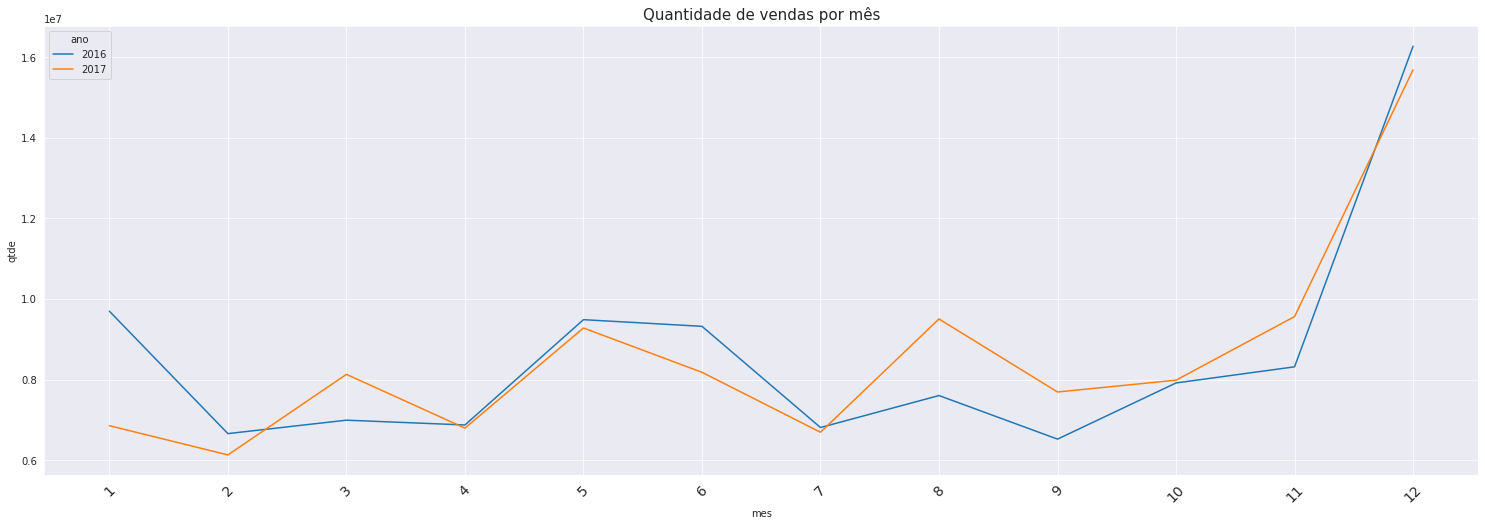

In [120]:
grouped_month_year = faturamento_lojas_atuais.groupby(["ano","mes"]).sum().reset_index()
a4_dims = (25.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(range(1,13), range(1,13), fontsize=14, rotation=45)
plt.title("Quantidade de vendas por mês", fontsize=15)
sns.lineplot(x="mes",y="qtde",hue="ano",data=grouped_month_year,ax=ax,palette="tab10")

<AxesSubplot:title={'center':'Receita de vendas por mês'}, xlabel='mes', ylabel='receita'>

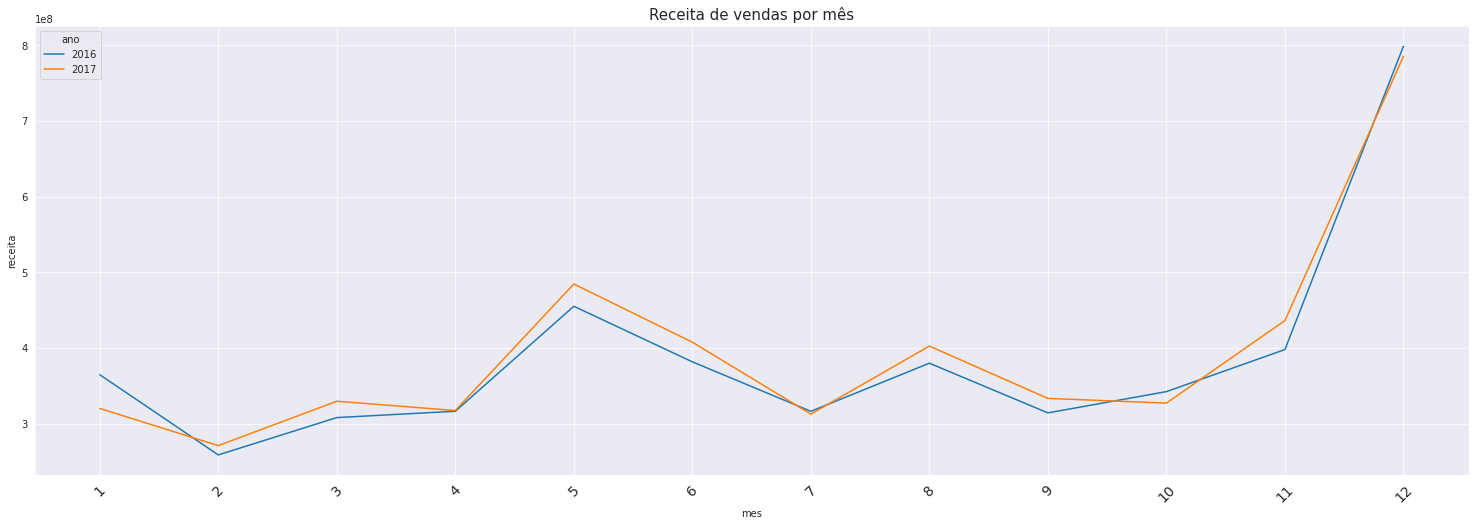

In [121]:
grouped_month_year = faturamento_lojas_atuais.groupby(["ano","mes"]).sum().reset_index()
a4_dims = (25.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(range(1,13), range(1,13), fontsize=14, rotation=45)
plt.title("Receita de vendas por mês", fontsize=15)
sns.lineplot(x="mes",y="receita",hue="ano",data=grouped_month_year,ax=ax,palette="tab10")

* Os graficos acima mostra uma tendência sazonal para ter mais vendas em épocas festivas, como por exemplo no natal, o que era esperado. As receitas se aproximam bastante, de forma que de um ano pra outra a diferença é praticamente mínima. Logo, um modelo treinado nos três primeiros meses pode ter bons resultados.
* Isto leva pode ser levado em consideração já que variável ano pode ser eliminada pois existe uma provável correlação baixa entre ano e receita

### 2.2 Distribuição das features categóricas

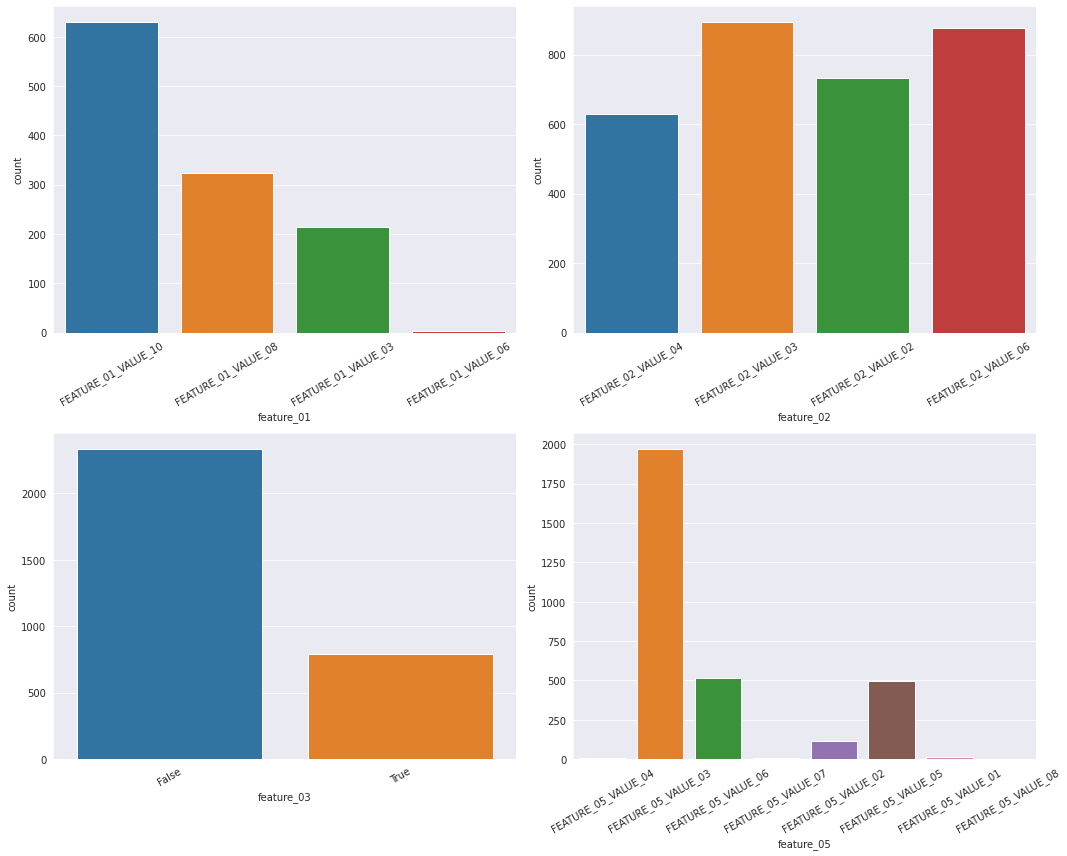

In [122]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,12))
axes[0,0].tick_params(axis='x', labelrotation=30)
axes[0,1].tick_params(axis='x', labelrotation=30)
axes[1,0].tick_params(axis='x', labelrotation=30)
axes[1,1].tick_params(axis='x', labelrotation=30)
sns.countplot(data=lojas_atuais,x="feature_01",ax=axes[0,0])
sns.countplot(data=lojas_atuais,x="feature_02",ax=axes[0,1])
sns.countplot(data=lojas_atuais,x="feature_03",ax=axes[1,0])
sns.countplot(data=lojas_atuais,x="feature_05",ax=axes[1,1])
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

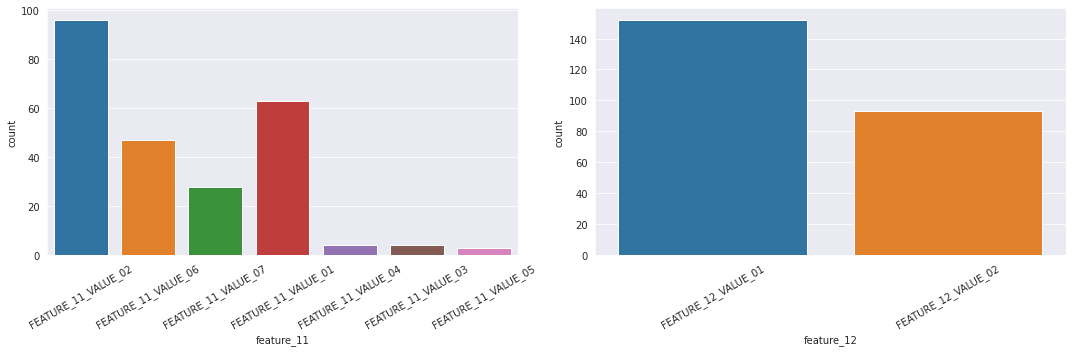

In [123]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].tick_params(axis='x', labelrotation=30)
axes[1].tick_params(axis='x', labelrotation=30)
sns.countplot(data=lojas_atuais,x="feature_11",ax=axes[0])
sns.countplot(data=lojas_atuais,x="feature_12",ax=axes[1])
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

* Somente a feature_02 traz uma distribuição mais balanceada. Alguns valores são praticamente próximos de zeros em algumas features como na feature_05 por exemplo.

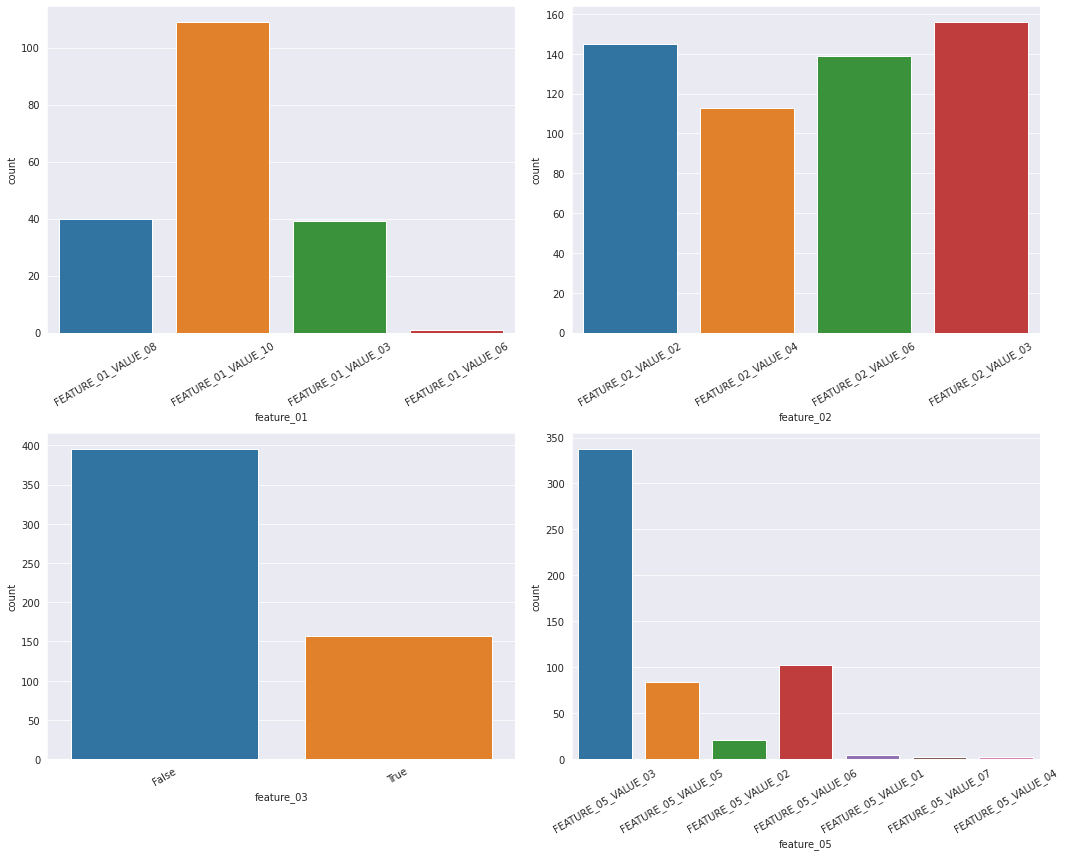

In [124]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,12))
axes[0,0].tick_params(axis='x', labelrotation=30)
axes[0,1].tick_params(axis='x', labelrotation=30)
axes[1,0].tick_params(axis='x', labelrotation=30)
axes[1,1].tick_params(axis='x', labelrotation=30)
sns.countplot(data=cenario_expansao,x="feature_01",ax=axes[0,0])
sns.countplot(data=cenario_expansao,x="feature_02",ax=axes[0,1])
sns.countplot(data=cenario_expansao,x="feature_03",ax=axes[1,0])
sns.countplot(data=cenario_expansao,x="feature_05",ax=axes[1,1])
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

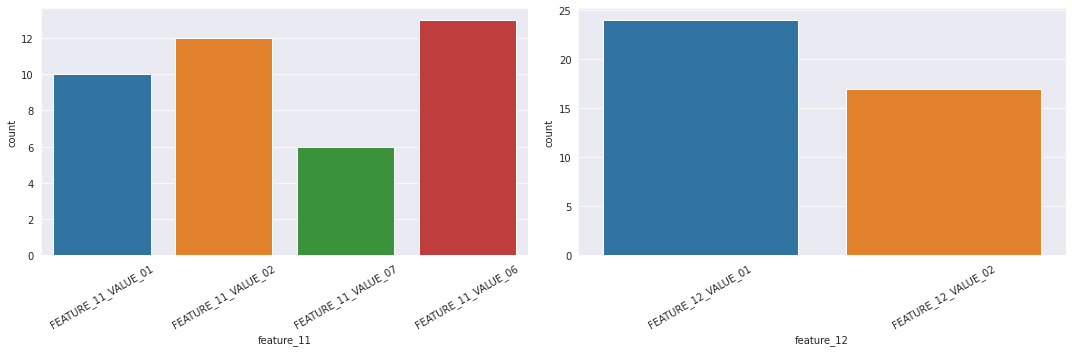

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].tick_params(axis='x', labelrotation=30)
axes[1].tick_params(axis='x', labelrotation=30)
sns.countplot(data=cenario_expansao,x="feature_11",ax=axes[0])
sns.countplot(data=cenario_expansao,x="feature_12",ax=axes[1])
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

* Percebemos acima que alguns valores da feature_11 e feature_05 estão presentes nos dados de lojas_atuais.csv mas não extão presente no cenario_expansão. Logo, isto pode influênciar no treinamento do modelo para o segundo desafio. Iremos eliminar os valores que não estão presente em ambox os dados: lojas_atuais.csv e cenario_expansao.csv

### 2.3 Distribuição das castegorias

In [126]:
faturamento_agrupado_categoria = faturamento_lojas_atuais.groupby("categoria").sum().reset_index()

<AxesSubplot:xlabel='categoria', ylabel='qtde'>

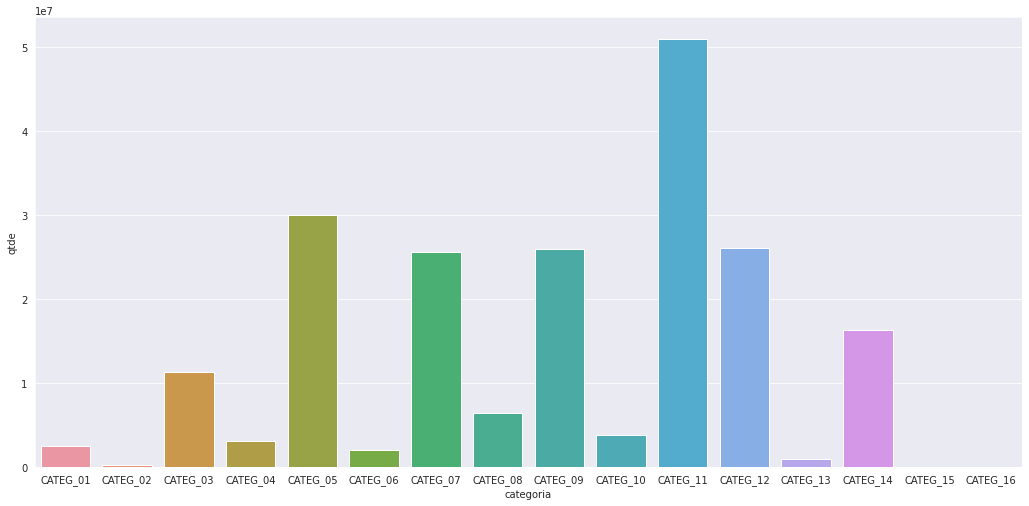

In [127]:
a4_dims = (17.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x="categoria", y="qtde",data=faturamento_agrupado_categoria, ax=ax)

<AxesSubplot:xlabel='categoria', ylabel='receita'>

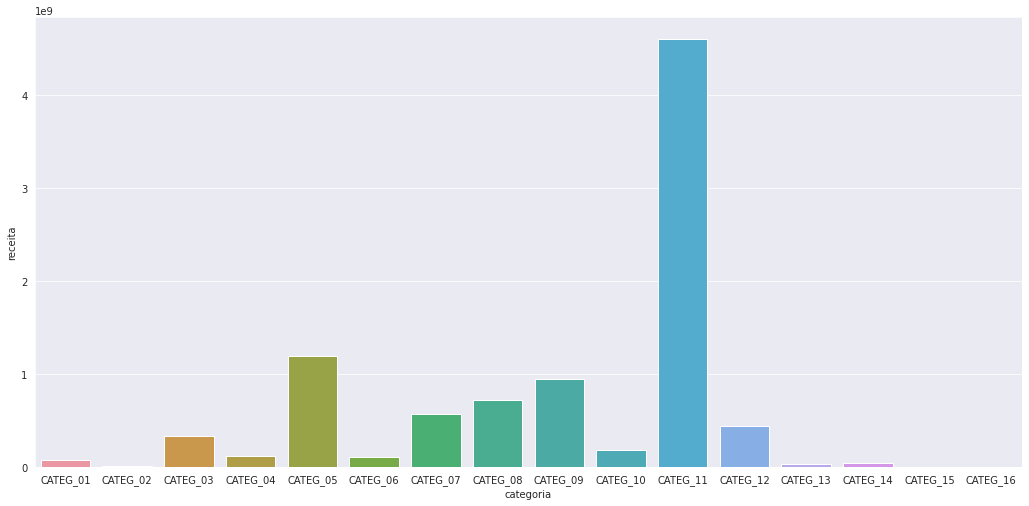

In [128]:
a4_dims = (17.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x="categoria", y="receita",data=faturamento_agrupado_categoria, ax=ax)

<AxesSubplot:xlabel='categoria', ylabel='mean'>

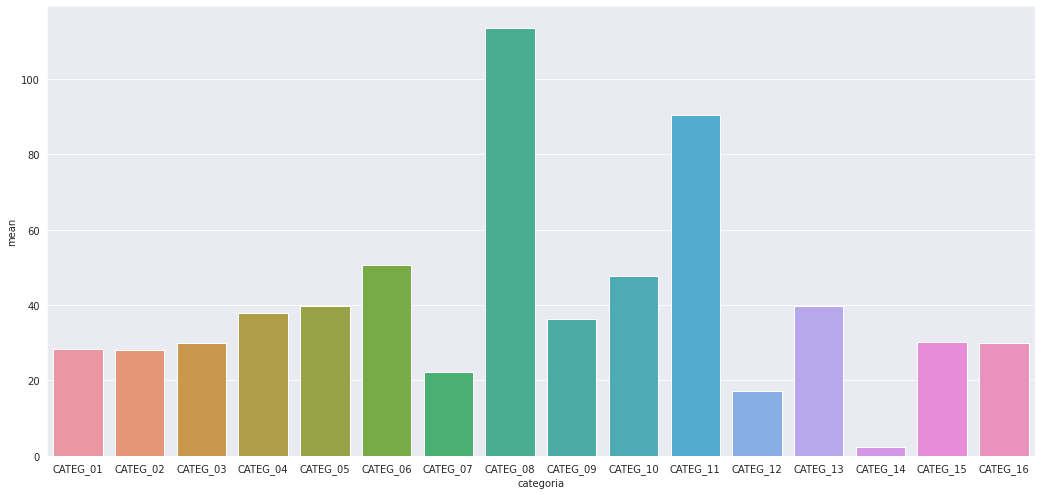

In [129]:
faturamento_agrupado_categoria["mean"] = faturamento_agrupado_categoria["receita"] / faturamento_agrupado_categoria["qtde"]
a4_dims = (17.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x="categoria", y="mean",data=faturamento_agrupado_categoria, ax=ax)

* Os barplots acima mostra que a maior quantidade de produto é vendido pela CATEG_11, sendo a mesma que traz mais receita. A CATEG_05 é a segundo que traz mais receita 
* As categorias CATEG_02, CATEG_15 e CATEG_16 são as que menos foram vendidos em quantidade e tem a receita menor. Poucas lojas devem vender essas categorias. 
* A média de 8 é maior, provávelmente produtos que vendem pouco mas são caros. 

### 2.5 Histograma de distribuição das features númericas 

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<AxesSubplot:title={'center':'feature_04'}>,
        <AxesSubplot:title={'center':'feature_06'}>,
        <AxesSubplot:title={'center':'feature_07'}>],
       [<AxesSubplot:title={'center':'feature_08'}>,
        <AxesSubplot:title={'center':'feature_09'}>,
        <AxesSubplot:title={'center':'feature_10'}>],
       [<AxesSubplot:title={'center':'feature_13'}>,
        <AxesSubplot:title={'center':'feature_14'}>,
        <AxesSubplot:title={'center':'feature_15'}>],
       [<AxesSubplot:title={'center':'feature_16'}>,
        <AxesSubplot:title={'center':'feature_17'}>,
        <AxesSubplot:title={'center':'feature_18'}>]], dtype=object)

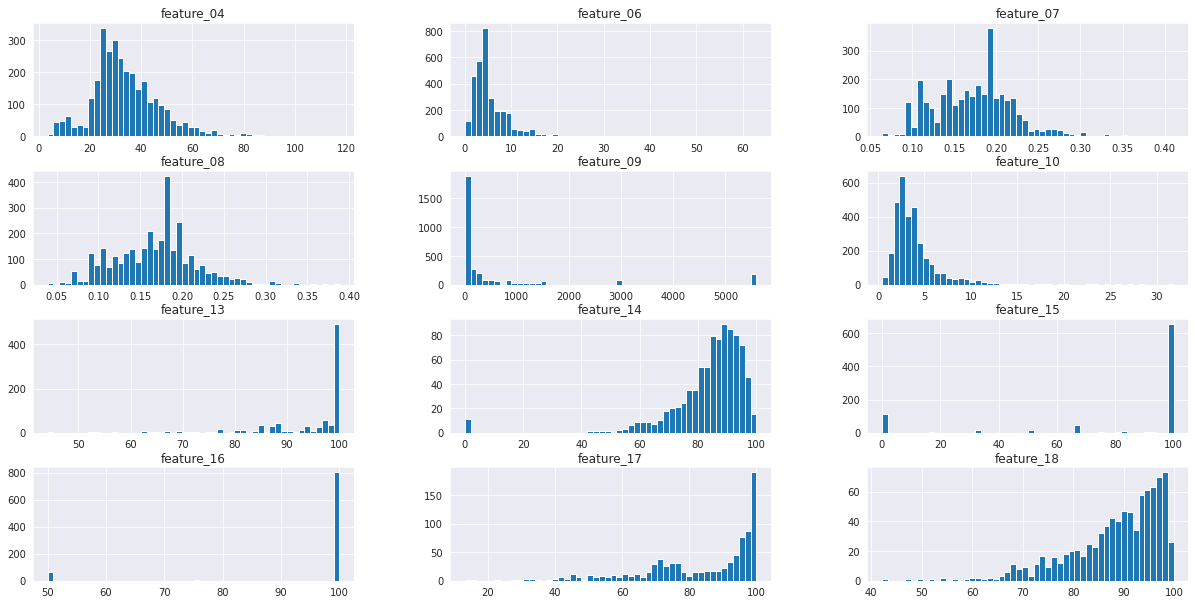

In [130]:
a4_dims = (20.7, 10.27)
fig, ax = plt.subplots(figsize=a4_dims)
lojas_atuais.select_dtypes(include=["int64","float64"]).drop(columns=["cod_loja","cod_municipio","cod_ap"]).hist(ax=ax,bins=50)

/home/felipemarcelino/.conda/envs/hackaton_big_data/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<AxesSubplot:title={'center':'feature_04'}>,
        <AxesSubplot:title={'center':'feature_06'}>,
        <AxesSubplot:title={'center':'feature_07'}>],
       [<AxesSubplot:title={'center':'feature_08'}>,
        <AxesSubplot:title={'center':'feature_09'}>,
        <AxesSubplot:title={'center':'feature_10'}>],
       [<AxesSubplot:title={'center':'feature_13'}>,
        <AxesSubplot:title={'center':'feature_14'}>,
        <AxesSubplot:title={'center':'feature_15'}>],
       [<AxesSubplot:title={'center':'feature_16'}>,
        <AxesSubplot:title={'center':'feature_17'}>,
        <AxesSubplot:title={'center':'feature_18'}>]], dtype=object)

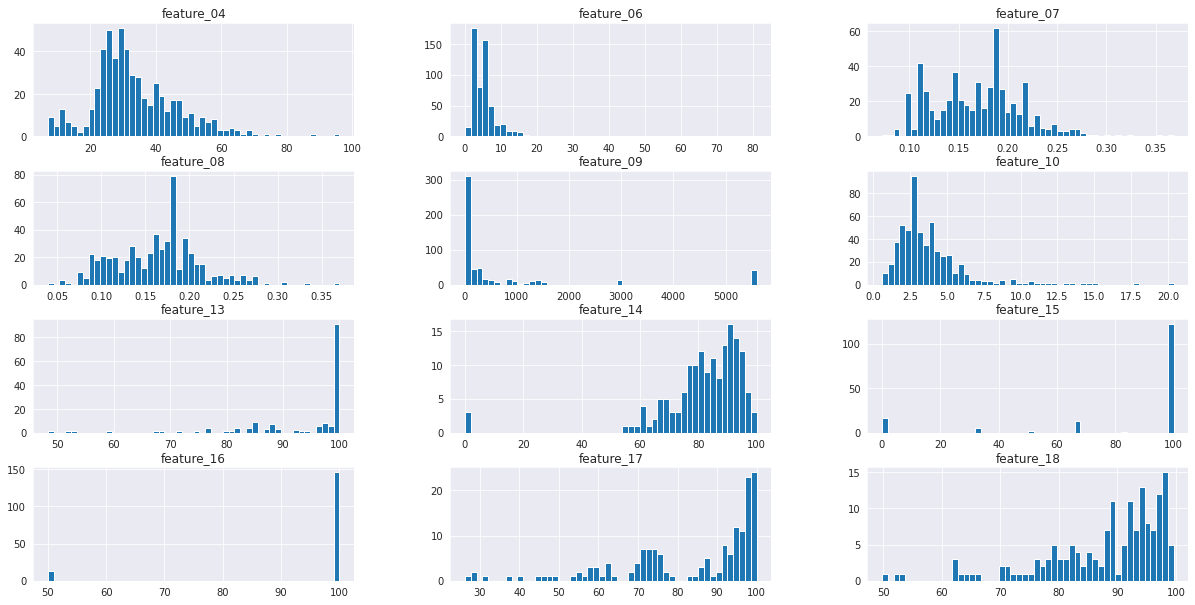

In [131]:
a4_dims = (20.7, 10.27)
fig, ax = plt.subplots(figsize=a4_dims)
cenario_expansao.select_dtypes(include=["int64","float64"]).drop(columns=["cod_loja","cod_municipio","cod_ap"]).hist(ax=ax,bins=50)

* Os histogramas acima clarea que cenáris em expansão e lojas atuais possuem distribuições iguais nas suas features númericas, o que é bom, facilitando o modelo a aprender certo padrões.
* As features feature_04, feature_06, feature_07, feature_08, feature_09, feature_10, feature_14 parecem seguir uma distribuição normal com assimetrias. 

## 3. Análise de correlação entre as variáveis

###  3.1 Análise entre as categorias 

In [132]:
categoria_somados = faturamento_lojas_atuais.pivot_table("qtde",["cod_loja",],["categoria"],aggfunc=np.sum, fill_value=0)
categoria_somados

categoria  CATEG_01  CATEG_02  CATEG_03  CATEG_04  CATEG_05  CATEG_06  \
cod_loja                                                                
1              4448      2110     46464      7999     47017      6996   
2              1875        48      1623       382      5273      1109   
3              1211       167      5163      1691     15525       965   
4               519        61      3211       884      6546       498   
5              1326       125      5443      1105     16854      1492   
...             ...       ...       ...       ...       ...       ...   
3682           1217       191      4790      1199     10149      1226   
3683            369        16      2380       816     11451       282   
3685           1825       399      8661      2010     12890      2282   
3686            522        44      3912       943      6970       890   
3687            560        73      2768       885      6698       437   

categoria  CATEG_07  CATEG_08  CATEG_09  CATEG_10  CATEG_11  CATEG_12  \
cod_loja                                                                
1             33879     12629     38541      8929     98315     43596   
2              3256      1162      7626       655      6585      3304   
3             11314      2430     16725      1791     22424     13298   
4              6690       996      5197       582      5051      6275   
5              7784      4527     13091      2897     32324      9628   
...             ...       ...       ...       ...       ...       ...   
3682           9894      3753     10539      1358     18083      6191   
3683          10723      2266      7192      1284     27997     11852   
3685          16570      2571     20754      1900     21888     14305   
3686           7858      2089      7752      1181     10269      8995   
3687           6394       813      6246       941      6439      7203   

categoria  CATEG_13  CATEG_14  CATEG_15  CATEG_16  
cod_loja                                           
1              5755      3705         0         0  
2               142      3336         0         0  
3               397      8118         0         0  
4               227      2195         0         0  
5               428     12939         0         0  
...             ...       ...       ...       ...  
3682            367      2284         0         0  
3683            407      9960         0         0  
3685            847      3336         2         0  
3686            271      4923         0         0  
3687            292      1727         0         0  

[3130 rows x 16 columns]

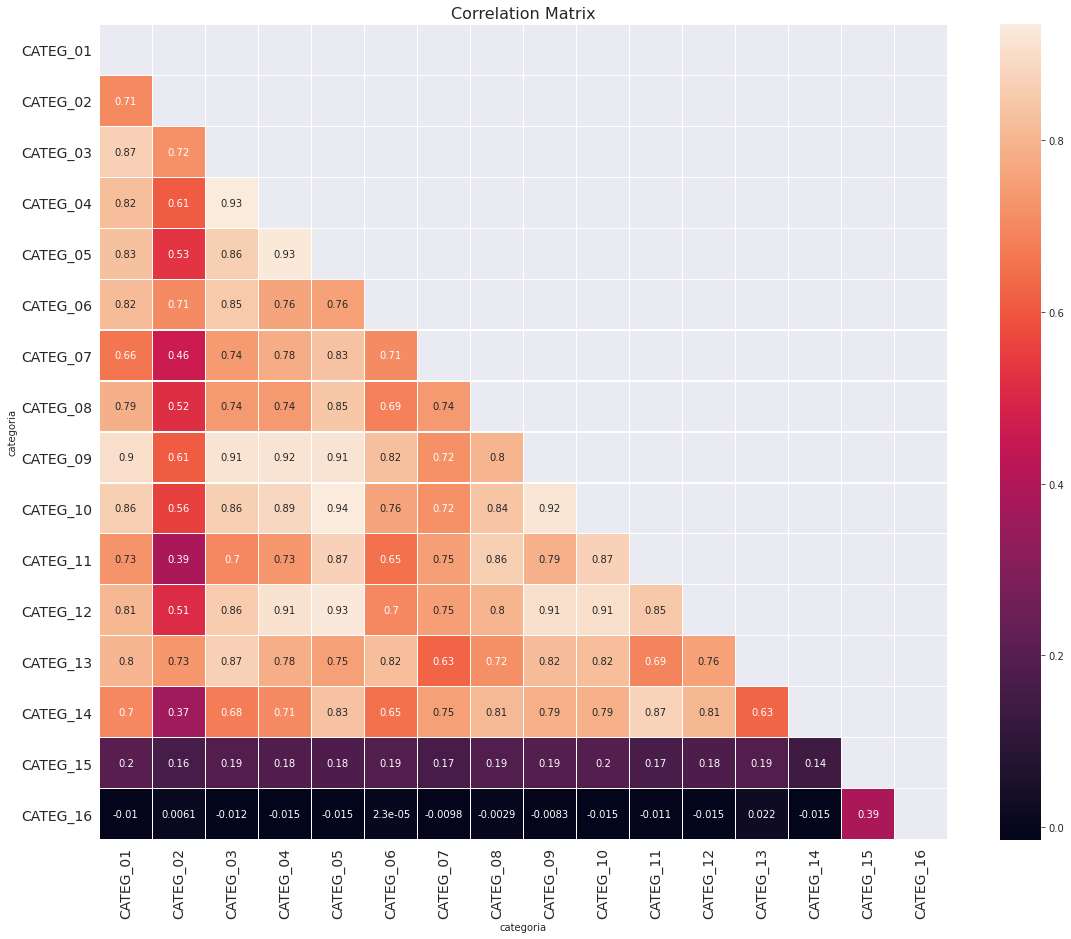

In [133]:
f = plt.figure(figsize=(19, 15))
corr = categoria_somados.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.xticks(range(categoria_somados.shape[1]), categoria_somados.columns, fontsize=14, rotation=45)
plt.yticks(range(categoria_somados.shape[1]), categoria_somados.columns, fontsize=14)
plt.title('Correlation Matrix', fontsize=16);
sns.heatmap(corr, annot=True, mask=mask,linewidths=0.15)
plt.show()

* É possível observar uma forte relação entre as categorias CATEG_04 e CATEG_03, provavelmente são produtos que saem juntos da loja, como por exemplo um computador(eletrônico) e uma mesa pra computador(móvel). 

###  3.2 Análise entre qtde e receita

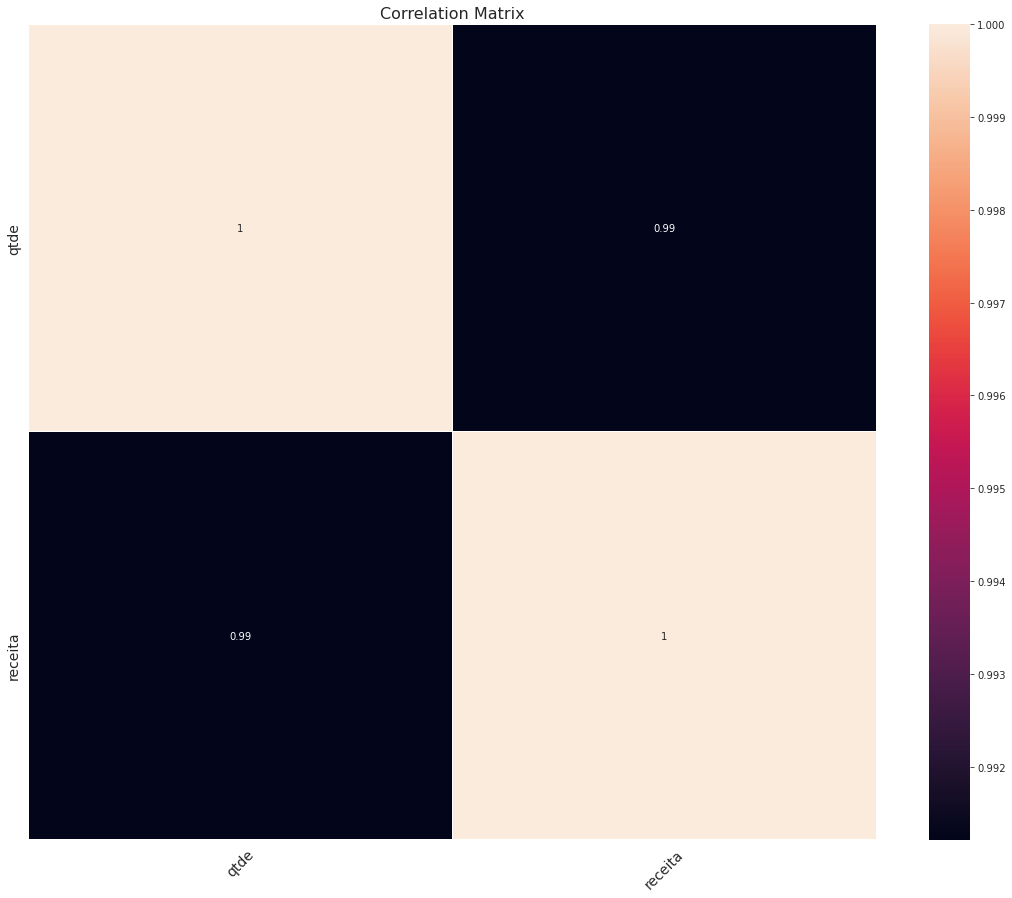

In [134]:
corr = faturamento_agrupado_mes_ano_loja[["qtde","receita"]].corr()
f = plt.figure(figsize=(19, 15))
plt.xticks(range(categoria_somados.shape[1]), categoria_somados.columns, fontsize=14, rotation=45)
plt.yticks(range(categoria_somados.shape[1]), categoria_somados.columns, fontsize=14)
plt.title('Correlation Matrix', fontsize=16);
sns.heatmap(corr, annot=True,linewidths=0.15)
plt.show()

* Quanto maior a quantidade vendida maior é a receita para cada um das lojas. O que era esperado inicialmente.

### 3.3 Correlação entre os meses 

In [135]:
faturamento_agrupado_mes_ano = faturamento_lojas_atuais.groupby(["mes","ano","cod_loja"]).sum().reset_index()
faturamento_agrupado_mes_ano.head()

mes   ano  cod_loja     qtde   receita
0    1  2016         1 13034.00 441833.37
1    1  2016         2  1425.00  54660.39
2    1  2016         3  4352.00 161428.96
3    1  2016         4  1738.00  54363.21
4    1  2016         5  5800.00 248834.01

In [136]:
faturamento_agrupado_mes_ano['mes_ano'] = faturamento_agrupado_mes_ano[['ano', 'mes']].astype(str).apply(lambda x: '_'.join(x), axis=1)
faturamento_agrupado_mes_ano_loja = faturamento_agrupado_mes_ano.pivot_table("receita",["cod_loja"],["mes_ano"])
faturamento_agrupado_mes_ano_loja.head()

mes_ano     2016_1   2016_10   2016_11    2016_12    2016_2    2016_3  \
cod_loja                                                                
1        441833.37 611797.30 876921.63 1257613.00 395340.22 587810.18   
2         54660.39  53209.15  53830.14  108589.21  49120.72  53421.91   
3        161428.96 198425.47 199192.78  422565.37 132417.93 139495.61   
4         54363.21  41540.57  57029.49  168548.71  38433.23  43751.17   
5        248834.01 219199.82 250667.71  431426.39 182297.02 210579.83   

mes_ano     2016_4    2016_5    2016_6    2016_7  ...   2017_11    2017_12  \
cod_loja                                          ...                        
1        534618.84 595477.92 589947.05 563814.03  ... 891173.22 1216996.84   
2         60167.41  89412.94  68925.00  69741.67  ...  76670.53   92232.32   
3        147895.60 210103.96 173810.84 137311.66  ... 204050.94  420197.90   
4         38245.63  66096.71  60945.98  45347.35  ...  64706.32  173683.70   
5        202545.65 343893.54 256717.01 223261.58  ... 203650.34  412462.37   

mes_ano     2017_2    2017_3    2017_4    2017_5    2017_6    2017_7  \
cod_loja                                                               
1        483610.18 626291.59 612062.60 748281.98 700312.65 646369.23   
2         39019.13  62446.56  52944.17  86638.16  76081.09  60697.95   
3        130868.47 141768.81 134988.33 220139.70 202257.56 132580.46   
4         42445.06  51014.55  44013.26  66607.47  59034.85  42618.25   
5        151167.08 177428.43 169632.23 285896.56 246040.77 177883.45   

mes_ano     2017_8    2017_9  
cod_loja                      
1        757850.68 602313.53  
2         72463.56  64936.11  
3        173861.61 142303.83  
4         58756.90  50140.08  
5        220496.40 179435.96  

[5 rows x 24 columns]

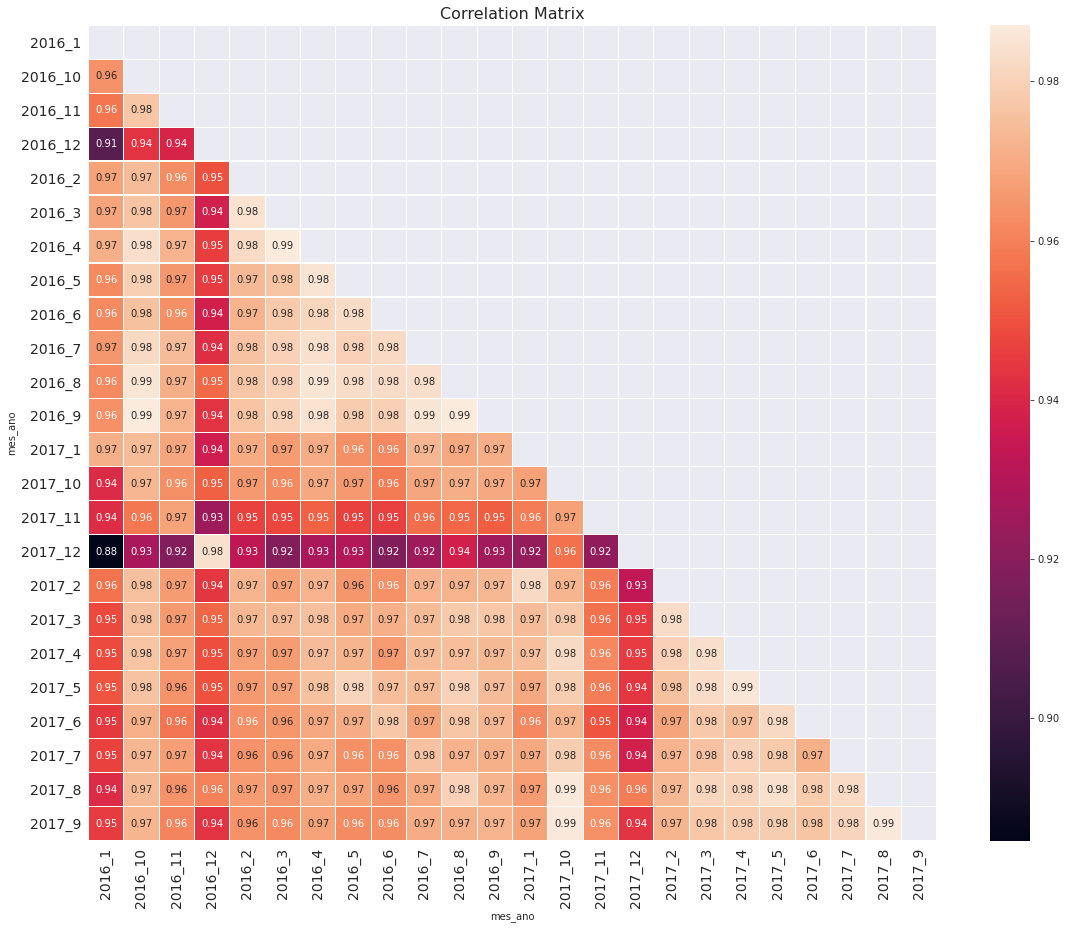

In [137]:

f = plt.figure(figsize=(19, 15))
corr = faturamento_agrupado_mes_ano_loja.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.xticks(range(faturamento_agrupado_mes_ano_loja.shape[1]), faturamento_agrupado_mes_ano_loja.columns, fontsize=14, rotation=45)
plt.yticks(range(faturamento_agrupado_mes_ano_loja.shape[1]), faturamento_agrupado_mes_ano_loja.columns, fontsize=14)
plt.title('Correlation Matrix', fontsize=16);
sns.heatmap(corr, annot=True, mask=mask, linewidths=.15)
plt.show()

* Existe uma correlação forte entre os meses de final de ano. 
* Existe uma correlação forte entre os mesmos meses de anos diferentes. 
    * Provavelmente dêvido ao fato das vendas ser sazonais e terem o mesmo comportamento mostrado nos gráficos acima de linha
* Provavelmente o treinamento por mês(dividindo por ano) será um bom modelo para o desafio 1

### 4 Feature Engineering 

### 4.1 Preenchendo munícipios com nan - Removido do modelo final

Remover o -1  e preencher com NaN apenas pra ficar conciso com os outros dados faltantes.

In [138]:
lojas_atuais.loc[lojas_atuais['cod_municipio'] == -1, 'cod_municipio'] = np.nan
lojas_atuais.loc[lojas_atuais['cod_ap'] == -1, 'cod_ap'] = np.nan 
cenario_expansao.loc[cenario_expansao['cod_municipio'] == -1, 'cod_municipio'] = np.nan
cenario_expansao.loc[cenario_expansao['cod_ap'] == -1, 'cod_ap'] = np.nan 

In [139]:
lojas_atuais.isnull().sum()

cod_loja            0
cod_ap            151
cod_municipio     151
feature_01       1959
feature_02          0
feature_03          0
feature_04          0
feature_05          0
feature_06          0
feature_07          0
feature_08          0
feature_09          0
feature_10          0
feature_11       2885
feature_12       2885
feature_13       2256
feature_14       2256
feature_15       2256
feature_16       2256
feature_17       2256
feature_18       2256
dtype: int64

In [140]:
cenario_expansao.isnull().sum()

cod_loja           0
cod_ap            30
cod_municipio     30
feature_01       364
feature_02         0
feature_03         0
feature_04         0
feature_05         0
feature_06         0
feature_07         0
feature_08         0
feature_09         0
feature_10         0
feature_11       512
feature_12       512
feature_13       394
feature_14       394
feature_15       394
feature_16       394
feature_17       394
feature_18       394
dtype: int64

### 4.2 Transformando em one-hot-encoding

In [141]:
feature_01_dummy = pd.get_dummies(lojas_atuais.feature_01)
feature_02_dummy = pd.get_dummies(lojas_atuais.feature_02)
feature_05_dummy = pd.get_dummies(lojas_atuais.feature_05)
feature_11_dummy = pd.get_dummies(lojas_atuais.feature_11)
feature_12_dummy = pd.get_dummies(lojas_atuais.feature_12)
lojas_atuais_encoding = pd.concat([lojas_atuais,feature_01_dummy,feature_02_dummy,feature_05_dummy,feature_11_dummy,feature_12_dummy],axis=1)
lojas_atuais_encoding.head()

cod_loja           cod_ap  cod_municipio           feature_01  \
0         1 4125506005002.00     4125506.00                  NaN   
1         2 5300108005004.00     5300108.00                  NaN   
2         3 3550308005052.00     3550308.00                  NaN   
3         4 3145604003002.00     3145604.00                  NaN   
4         5 1600303005010.00     1600303.00  FEATURE_01_VALUE_10   

            feature_02  feature_03  feature_04           feature_05  \
0  FEATURE_02_VALUE_04        True       21.76  FEATURE_05_VALUE_04   
1  FEATURE_02_VALUE_03        True       22.00  FEATURE_05_VALUE_03   
2  FEATURE_02_VALUE_03        True       45.66  FEATURE_05_VALUE_03   
3  FEATURE_02_VALUE_04       False       30.00  FEATURE_05_VALUE_03   
4  FEATURE_02_VALUE_02       False       62.49  FEATURE_05_VALUE_03   

   feature_06  feature_07  ...  FEATURE_05_VALUE_08  FEATURE_11_VALUE_01  \
0          31        0.17  ...                    0                    0   
1          27        0.22  ...                    0                    0   
2           6        0.19  ...                    0                    0   
3           3        0.14  ...                    0                    0   
4          30        0.11  ...                    0                    0   

   FEATURE_11_VALUE_02 FEATURE_11_VALUE_03 FEATURE_11_VALUE_04  \
0                    0                   0                   0   
1                    0                   0                   0   
2                    0                   0                   0   
3                    0                   0                   0   
4                    1                   0                   0   

   FEATURE_11_VALUE_05  FEATURE_11_VALUE_06  FEATURE_11_VALUE_07  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   FEATURE_12_VALUE_01  FEATURE_12_VALUE_02  
0                    0                    0  
1                    0                    0  
2                    0                    0  
3                    0                    0  
4                    1                    0  

[5 rows x 46 columns]

In [142]:
feature_01_dummy = pd.get_dummies(cenario_expansao.feature_01)
feature_02_dummy = pd.get_dummies(cenario_expansao.feature_02)
feature_05_dummy = pd.get_dummies(cenario_expansao.feature_05)
feature_11_dummy = pd.get_dummies(cenario_expansao.feature_11)
feature_12_dummy = pd.get_dummies(cenario_expansao.feature_12)
cenario_expansao_encoding = pd.concat([cenario_expansao,feature_01_dummy,feature_02_dummy,feature_05_dummy,feature_11_dummy,feature_12_dummy],axis=1)
cenario_expansao_encoding.head()

cod_loja           cod_ap  cod_municipio           feature_01  \
0        10 2933307005008.00     2933307.00  FEATURE_01_VALUE_08   
1        13 2916401003002.00     2916401.00  FEATURE_01_VALUE_10   
2        16 2928703003003.00     2928703.00                  NaN   
3        21 2906006003001.00     2906006.00                  NaN   
4        28 3550308005058.00     3550308.00  FEATURE_01_VALUE_10   

            feature_02  feature_03  feature_04           feature_05  \
0  FEATURE_02_VALUE_02       False       50.00  FEATURE_05_VALUE_03   
1  FEATURE_02_VALUE_04       False       41.00  FEATURE_05_VALUE_03   
2  FEATURE_02_VALUE_04       False       42.12  FEATURE_05_VALUE_05   
3  FEATURE_02_VALUE_04       False       30.00  FEATURE_05_VALUE_03   
4  FEATURE_02_VALUE_02        True       44.31  FEATURE_05_VALUE_03   

   feature_06  feature_07  ...  FEATURE_05_VALUE_04  FEATURE_05_VALUE_05  \
0           6        0.13  ...                    0                    0   
1           4        0.12  ...                    0                    0   
2           2        0.10  ...                    0                    1   
3           6        0.13  ...                    0                    0   
4           8        0.19  ...                    0                    0   

   FEATURE_05_VALUE_06 FEATURE_05_VALUE_07 FEATURE_11_VALUE_01  \
0                    0                   0                   1   
1                    0                   0                   0   
2                    0                   0                   0   
3                    0                   0                   0   
4                    0                   0                   0   

   FEATURE_11_VALUE_02  FEATURE_11_VALUE_06  FEATURE_11_VALUE_07  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    1                    0                    0   

   FEATURE_12_VALUE_01  FEATURE_12_VALUE_02  
0                    1                    0  
1                    0                    0  
2                    0                    0  
3                    0                    0  
4                    1                    0  

[5 rows x 42 columns]

In [143]:
lojas_atuais_encoding = lojas_atuais_encoding.drop(columns=["feature_01","feature_02","feature_05","feature_11","feature_12"])
lojas_atuais_encoding.head()

cod_loja           cod_ap  cod_municipio  feature_03  feature_04  \
0         1 4125506005002.00     4125506.00        True       21.76   
1         2 5300108005004.00     5300108.00        True       22.00   
2         3 3550308005052.00     3550308.00        True       45.66   
3         4 3145604003002.00     3145604.00       False       30.00   
4         5 1600303005010.00     1600303.00       False       62.49   

   feature_06  feature_07  feature_08  feature_09  feature_10  ...  \
0          31        0.17        0.17      115.96        2.35  ...   
1          27        0.22        0.20     1562.67        3.67  ...   
2           6        0.19        0.18     5593.91        2.82  ...   
3           3        0.14        0.14       12.82        7.22  ...   
4          30        0.11        0.10      325.53        1.97  ...   

   FEATURE_05_VALUE_08  FEATURE_11_VALUE_01  FEATURE_11_VALUE_02  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    1   

   FEATURE_11_VALUE_03  FEATURE_11_VALUE_04  FEATURE_11_VALUE_05  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   FEATURE_11_VALUE_06  FEATURE_11_VALUE_07  FEATURE_12_VALUE_01  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    1   

   FEATURE_12_VALUE_02  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 41 columns]

In [144]:
cenario_expansao_encoding = cenario_expansao_encoding.drop(columns=["feature_01","feature_02","feature_05","feature_11","feature_12"])
cenario_expansao_encoding.head()

cod_loja           cod_ap  cod_municipio  feature_03  feature_04  \
0        10 2933307005008.00     2933307.00       False       50.00   
1        13 2916401003002.00     2916401.00       False       41.00   
2        16 2928703003003.00     2928703.00       False       42.12   
3        21 2906006003001.00     2906006.00       False       30.00   
4        28 3550308005058.00     3550308.00        True       44.31   

   feature_06  feature_07  feature_08  feature_09  feature_10  ...  \
0           6        0.13        0.13      116.19        2.91  ...   
1           4        0.12        0.11       26.35        1.31  ...   
2           2        0.10        0.09       35.36        1.97  ...   
3           6        0.13        0.13        9.86        1.38  ...   
4           8        0.19        0.18     5593.91        2.82  ...   

   FEATURE_05_VALUE_04  FEATURE_05_VALUE_05  FEATURE_05_VALUE_06  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    1                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   FEATURE_05_VALUE_07  FEATURE_11_VALUE_01  FEATURE_11_VALUE_02  \
0                    0                    1                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    1   

   FEATURE_11_VALUE_06  FEATURE_11_VALUE_07  FEATURE_12_VALUE_01  \
0                    0                    0                    1   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    1   

   FEATURE_12_VALUE_02  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 37 columns]

### 4.3 Extraindo os estados - Removido do modelo final

In [145]:
lojas_atuais_encoding["estado"] = cenario_expansao_encoding["cod_municipio"].astype(str).str[:2]
cenario_expansao_encoding["estado"] = cenario_expansao_encoding["cod_municipio"].astype(str).str[:2]

* Lojas localizadas nos estados do sudentes devem vender mais produtos do que outros estados. 

### 5 Manipulando dados externos

In [146]:
idh = pd.read_excel("./data/AtlasBrasil_Consulta.xlsx")
mun_populacao_2010 = pd.read_excel("./data/populacao_2010.xlsx")
mun_populacao_2017 = pd.read_excel("./data/populacao_2017.xlsx")
emprego = pd.read_excel("./data/municipiodesemprego.xlsx")

In [147]:
idh

Código       Espacialidades  IDHM 2010  IDHM Renda 2010  \
0          76               Brasil       0.73             0.74   
1     5200050      Abadia de Goiás       0.71             0.69   
2     3100104  Abadia dos Dourados       0.69             0.69   
3     5200100            Abadiânia       0.69             0.67   
4     3100203               Abaeté       0.70             0.72   
...       ...                  ...        ...              ...   
5561  2933604          Xique-Xique       0.58             0.56   
5562  2517407               Zabelê       0.62             0.57   
5563  3557154             Zacarias       0.73             0.69   
5564  2114007              Zé Doca       0.59             0.56   
5565  4219853               Zortéa       0.76             0.75   

      IDHM Longevidade 2010  Renda per capita 2010  
0                      0.82                 793.87  
1                      0.83                 574.96  
2                      0.84                 596.18  
3                      0.84                 519.87  
4                      0.85                 707.24  
...                     ...                    ...  
5561                   0.74                 265.25  
5562                   0.72                 272.94  
5563                   0.83                 605.79  
5564                   0.74                 259.21  
5565                   0.89                 861.63  

[5566 rows x 6 columns]

In [148]:
idh.isnull().sum()/len(idh)

Código                  0.00
Espacialidades          0.00
IDHM 2010               0.00
IDHM Renda 2010         0.00
IDHM Longevidade 2010   0.00
Renda per capita 2010   0.00
dtype: float64

In [149]:
mun_populacao_2010

Territorialidades População total 2010
0                                                Brasil            190755799
1                                  Abadia de Goiás (GO)                 6876
2                              Abadia dos Dourados (MG)                 6704
3                                        Abadiânia (GO)                15757
4                                           Abaeté (MG)                22690
...                                                 ...                  ...
5563                                       Zé Doca (MA)                50173
5564                                        Zortéa (SC)                 2991
5565                                                                        
5566  Elaboração: Atlas do Desenvolvimento Humano no...                  NaN
5567  Fontes: dados do IBGE e de registros administr...                  NaN

[5568 rows x 2 columns]

In [150]:
mun_populacao_2017

Territorialidades População total 2017
0                                                Brasil            207660929
1                                  Abadia de Goiás (GO)                 8207
2                              Abadia dos Dourados (MG)                 7059
3                                        Abadiânia (GO)                18775
4                                           Abaeté (MG)                23611
...                                                 ...                  ...
5563                                       Zé Doca (MA)                51084
5564                                        Zortéa (SC)                 3300
5565                                                                        
5566  Elaboração: Atlas do Desenvolvimento Humano no...                  NaN
5567  Fontes: dados do IBGE e de registros administr...                  NaN

[5568 rows x 2 columns]

In [151]:
mun_populacao_2010.isnull().sum()/len(mun_populacao_2010)

Territorialidades      0.00
População total 2010   0.00
dtype: float64

In [152]:
mun_populacao_2017.isnull().sum()/len(mun_populacao_2017)

Territorialidades      0.00
População total 2017   0.00
dtype: float64

In [153]:
emprego

Territorialidades  \
0                                                Brasil   
1                                  Abadia de Goiás (GO)   
2                              Abadia dos Dourados (MG)   
3                                        Abadiânia (GO)   
4                                           Abaeté (MG)   
...                                                 ...   
5563                                       Zé Doca (MA)   
5564                                        Zortéa (SC)   
5565                                                      
5566  Elaboração: Atlas do Desenvolvimento Humano no...   
5567  Fontes: dados do IBGE e de registros administr...   

     Taxa de atividade - 18 anos ou mais de idade 2010  \
0                                                66.54   
1                                                72.81   
2                                                65.97   
3                                                65.48   
4                                                65.90   
...                                                ...   
5563                                             56.39   
5564                                             84.08   
5565                                                     
5566                                               NaN   
5567                                               NaN   

      Taxa de desocupação - 18 anos ou mais de idade 2010  \
0                                                  7.29     
1                                                  4.39     
2                                                  3.78     
3                                                  3.16     
4                                                  4.38     
...                                                 ...     
5563                                               6.49     
5564                                               1.88     
5565                                                nan     
5566                                                nan     
5567                                                nan     

      % de ocupados de 18 anos ou mais de idade que são empregados com carteira 2010  \
0                                                 46.47                                
1                                                 39.40                                
2                                                 26.56                                
3                                                 28.32                                
4                                                 39.32                                
...                                                 ...                                
5563                                               9.50                                
5564                                              49.03                                
5565                                                nan                                
5566                                                nan                                
5567                                                nan                                

      % de ocupados de 18 anos ou mais de idade que são empregados sem carteira 2010  \
0                                                 19.33                                
1                                                 24.94                                
2                                                 18.65                                
3                                                 28.55                                
4                                                 28.38                                
...                                                 ...                                
5563                                              36.22                                
5564                                              11.48                                
5565                                              

In [154]:
emprego.isnull().sum()/len(emprego)

Territorialidades                                                                       0.00
Taxa de atividade - 18 anos ou mais de idade 2010                                       0.00
Taxa de desocupação - 18 anos ou mais de idade 2010                                     0.00
% de ocupados de 18 anos ou mais de idade que são empregados com carteira 2010          0.00
% de ocupados de 18 anos ou mais de idade que são empregados sem carteira 2010          0.00
% de ocupados de 18 anos ou mais de idade que são trabalhadores do setor público 2010   0.00
% de ocupados de 18 anos ou mais que são trabalhadores por conta própria 2010           0.00
% de ocupados de 18 anos ou mais que são empregadores 2010                              0.07
% dos ocupados com ensino fundamental completo 2010                                     0.00
% dos ocupados com ensino médio completo 2010                                           0.00
% dos ocupados com ensino superior completo 2010                      

* Nos dados acima somente uma parte dos dados de setor agropecuário e setores industriais estão faltando dados. 

In [155]:
def remove_state(string_data):
  return (re.sub(" \([^)]*\)", "",string_data))

In [156]:
mun_populacao_2010["Territorialidades"] = mun_populacao_2010["Territorialidades"].apply(lambda x: remove_state(x))
mun_populacao_2010.head()

Territorialidades População total 2010
0               Brasil            190755799
1      Abadia de Goiás                 6876
2  Abadia dos Dourados                 6704
3            Abadiânia                15757
4               Abaeté                22690

In [157]:
mun_populacao_2017["Territorialidades"] = mun_populacao_2017["Territorialidades"].apply(lambda x: remove_state(x))
mun_populacao_2017.head()

Territorialidades População total 2017
0               Brasil            207660929
1      Abadia de Goiás                 8207
2  Abadia dos Dourados                 7059
3            Abadiânia                18775
4               Abaeté                23611

In [158]:
emprego["Territorialidades"] = emprego["Territorialidades"].apply(lambda x: remove_state(x))
emprego.head()

Territorialidades Taxa de atividade - 18 anos ou mais de idade 2010  \
0               Brasil                                             66.54   
1      Abadia de Goiás                                             72.81   
2  Abadia dos Dourados                                             65.97   
3            Abadiânia                                             65.48   
4               Abaeté                                             65.90   

   Taxa de desocupação - 18 anos ou mais de idade 2010  \
0                                               7.29     
1                                               4.39     
2                                               3.78     
3                                               3.16     
4                                               4.38     

   % de ocupados de 18 anos ou mais de idade que são empregados com carteira 2010  \
0                                              46.47                                
1                                              39.40                                
2                                              26.56                                
3                                              28.32                                
4                                              39.32                                

   % de ocupados de 18 anos ou mais de idade que são empregados sem carteira 2010  \
0                                              19.33                                
1                                              24.94                                
2                                              18.65                                
3                                              28.55                                
4                                              28.38                                

   % de ocupados de 18 anos ou mais de idade que são trabalhadores do setor público 2010  \
0                                               5.61                                       
1                                               8.65                                       
2                                              10.22                                       
3                                               7.05                                       
4                                               5.49                                       

   % de ocupados de 18 anos ou mais que são trabalhadores por conta própria 2010  \
0                                              21.73                               
1                                              24.49                               
2                                              36.21                               
3                                              32.61                               
4                                              20.69                               

   % de ocupados de 18 anos ou mais que são empregadores 2010  \
0                                               2.05            
1                                               0.73            
2                                               0.20            
3                                               0.48            
4                                               1.88            

   % dos ocupados com ensino fundamental completo 2010  \
0                                              62.29     
1                                              52.98     
2                                              42.63     
3                                              48.83     
4                                              39.89     

   % dos ocupados com ensino médio completo 2010  \
0                                          44.91   
1                                          31.97   
2                                          20.54   
3                                          31.03   
4                                          25.32   

   % dos ocupados com ensino superior completo 2010  \
0          

## 6. Modelagem 

### Modelagem Desafio 1 

* Os modelos estão dentro do notebook desafio_1 e desafio_2. A separação é apenas para deixar o código de mais fácil manuseio 
* **A TABELA EMPREGO NÃO GEROU NENHUM BENEFÍCIO PARA O MODELO** 